# Deep Learning Coursework 2

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/DL_CW2/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DL_CW2


## Question 3.4 : Bag of Vectors

In [2]:
# Import libraries

# General 
import os, json
import numpy as np
import re
from matplotlib import pyplot as plt
import random
from sklearn.preprocessing import OneHotEncoder
from itertools import product

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import torch.nn.functional as F

# Set device
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

torch.cuda.get_device_name()

'Tesla T4'

A common baseline before the advent of deep learning in natural language processing, was a “bag of words” model where one would take an input of a sequence of words and create a one-hot vector of the size of all words in the dataset and mark the presence of a word in the input by binary setting an index associated with that word in the vector. This accomplishes the task of turning a variable-length input such as a sentence, into a fixed-size input that is easier to process using for example a logistic-regression layer. For many years this proved to be a surprisingly – sometimes even frustratingly –strong baseline for many tasks, despite the fact that it creates a model that is oblivious to the order ofthe words in the input.

Nowadays it is more common to use a “neuralised” version of this model, where instead of creating a binary vector, each word is first mapped to a fixed-size embedding – commonly these embeddings are pre-trained, using a method such as “word2vec”.  Then, one or several pooling operations is applied to the embeddings, to turn them into a fixed-size representation. Popular choices for pooling include element-wise mean, max, and min. If more than one pooling operation is used, the resulting vector for each pooling operation is concatenated, this representation is then passed to a multi-layerperceptron to provide a classification decision. Just like its ancestor the “bag of words”, this “bag of vectors” can be surprisingly difficult to beat, despite it also being completely ignorant of the word order in its input.

To complete this task you are expected to:

1. Implement a bag of vectors model with a cross-entropy loss for the Stanford Sentiment Treebank data, based on the pre-trained word2vec embeddings provided in the Assignment Colaboratory notebook.

**Load Data :**

In [3]:
# Load sentences from SST dataset
def loadsst(path):
    xs = []
    ys = []
    file1 = open(path, 'r')
    Lines = file1.readlines()
    for line in Lines:
        soup = line.split()
        ys.append(int(soup[0].lstrip('(')))
        tokens = []
        for chunk in soup[2:]:
            if not chunk.endswith(")"):
                continue
            tokens.append(chunk.rstrip(')'))
        xs.append(tokens)
    return xs, np.array(ys)

# Cleanup sentences using text processing with regex
def cleanup_sentences(sentences):
    cleaned_sentences = []
    for sentence in sentences:
        text = ' '.join(sentence)
        # remove punctuation
        text = re.sub('[^a-zA-Z0-9]', ' ', text)
        # remove multiple spaces
        text = re.sub(r' +', ' ', text)
        # remove newline
        text = re.sub(r'\n', ' ', text)
        cleaned_sentences.append(text.split())
    return cleaned_sentences

# Load train, val and test sets
train_x, train_y = loadsst("train.txt")
val_x, val_y = loadsst("dev.txt")
test_x, test_y = loadsst("test.txt")

# Cleanup sentences in datasets
train_x = cleanup_sentences(train_x) 
val_x = cleanup_sentences(val_x)
test_x = cleanup_sentences(test_x)

In [4]:
# Inspect sample data
random.seed(1)
for i in range(31):
  i = random.randint(1, len(train_x))
  print(train_y[i], " : " , " ".join(train_x[i]))

2  :  It is there to give them a good time
4  :  The Emperor s Club ruthless in its own placid way finds one of our most conservative and hidebound movie making traditions and gives it new texture new relevance new reality
1  :  There s no point in extracting the bare bones of Byatt s plot for purposes of bland Hollywood romance
2  :  OK arthouse
0  :  You have no affinity for most of the characters
1  :  Real life strongman Ahola lacks the charisma and ability to carry the film on his admittedly broad shoulders
3  :  An encouraging effort from McCrudden
2  :  Your taste for Jonah A Veggie Tales Movie may well depend on your threshold for pop manifestations of the Holy Spirit
2  :  Underachieves only in not taking the Shakespeare parallels quite far enough
4  :  It s a fun adventure movie for kids LRB of all ages RRB that like adventure
0  :  The characters are paper thin and their personalities undergo radical changes when it suits the script
3  :  Plays out with a dogged and eventual

**Load Word2Vec Pretrained embeddings**

In [5]:
# Load pretrained word2vec embeddings
from gensim.models import KeyedVectors
w2v = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
weights = torch.FloatTensor(w2v.vectors)

**Create PyTorch Dataset of the Data**

In [6]:
# Create Data Class
class Data(Dataset):

  # Constructor
  def __init__(self, x_values, y_values, embedding):

    # For passing the sentences to the model, we need to convert the words in each sentence to and index of the word in the word2vec vocab.
    # If the word is not in the vocab, then we substitute with "UNK"
    # Because the sentences are of varied length, we also pad with the "UNK" to fix the length
    self.x = self.sentences2indxs(sentences=x_values, embedding=embedding, padding_value=0)

    # Store the sentence sentiment classes as a tensor
    self.y = torch.as_tensor(y_values)

    # store number of sentences in the dataset
    self.len = self.y.size()[0]
    
  # Getter
  def __getitem__(self, index):
    return self.x[index], self.y[index]

  # Get Length
  def __len__(self):
    return self.len

  # Create indices representation of each sentence
  def sentences2indxs(self, sentences, embedding, padding_value):

    # Stores indices representation for each sentence
    idxs = []
    for sentence in sentences:
      # Store indices representation for a single sentence
      idx = []
      for word in sentence:
        if word in w2v:
          idx.append(embedding.vocab[word].index)
        else:
          idx.append(embedding.vocab["UNK"].index)
      idx = torch.as_tensor(idx)
      idxs.append(idx)

    # Pad sentences:
    padded = pad_sequence(idxs, batch_first=True, padding_value=padding_value)
    return padded

In [7]:
# Create Pytorch datasets for the train, val and test data
train_data = Data(train_x, train_y, w2v)
print("Number of training examples = {}".format(len(train_data)))

val_data = Data(val_x, val_y, w2v)
print("Number of validation examples = {}".format(len(val_data)))

test_data = Data(test_x, test_y, w2v)
print("Number of testing examples = {}".format(len(test_data)))

Number of training examples = 8544
Number of validation examples = 1101
Number of testing examples = 2210


**Create PyTorch MLP Model**

In [8]:
# Create model
class MLP(nn.Module):

  # Constructor
  def __init__(self, Layers, embeddings, pool_type="mean", train_embed=False):
    super(MLP, self).__init__()

    # Configure embeddings layer
    # Make the embedding learnable if train_embed=True
    if train_embed:
      self.embeddings = nn.Embedding.from_pretrained(embeddings, freeze=False)
    else:
      self.embeddings = nn.Embedding.from_pretrained(embeddings, freeze=True)
    
    # Set the pooling type. Can be either "mean", "max", "min"
    self.pool_type= pool_type

    # Configure MLP
    self.hidden = nn.ModuleList()
    for input_size, output_size in zip(Layers, Layers[1:]):
      self.hidden.append(nn.Linear(input_size, output_size))
    
  # Prediction
  def forward(self, inputs):

    # Compute the embeddings for sentence
    embeds = self.embeddings(inputs)

    # Perform mean/max/min pooling on embeddings to create a 300-d representation
    if self.pool_type == "mean":
      activation = torch.mean(embeds, axis=1)
    elif self.pool_type == "max":
      activation, _ = torch.max(embeds, axis=1)
    elif self.pool_type == "min":
      activation, _ = torch.min(embeds, axis=1)
    elif self.pool_type == "mean-max":
      activation_mean = torch.mean(embeds, axis=1)
      activation_max, _ = torch.max(embeds, axis=1)
      activation = torch.cat((activation_mean, activation_max), 1)
    elif self.pool_type == "max-min":
      activation_max, _ = torch.max(embeds, axis=1)
      activation_min, _ = torch.min(embeds, axis=1)
      activation = torch.cat((activation_max, activation_min), 1)
    elif self.pool_type == "mean-min":
      activation_mean = torch.mean(embeds, axis=1)
      activation_min, _ = torch.min(embeds, axis=1)
      activation = torch.cat((activation_mean, activation_min), 1)
    elif self.pool_type == "all":
      activation_mean = torch.mean(embeds, axis=1)
      activation_max, _ = torch.max(embeds, axis=1)
      activation_min, _ = torch.min(embeds, axis=1)
      activation = torch.cat((activation_mean, activation_max, activation_min), 1)
    else:
      raise Exception("Pool type can be either \"mean\" , \"max\" or \"min\".")

    # Pass through MLP
    L = len(self.hidden)
    for (l, linear_transform) in zip(range(L), self.hidden):
      if l < L - 1:
        activation = F.relu(linear_transform(activation))
      else:
        activation = linear_transform(activation)

    return activation

**Setup the training function**

In [9]:
# Accuracy function
def calc_acc(model, dataset, device=device):
  x = dataset.x.to(device)
  y = dataset.y
  with torch.no_grad():
    yhat = model(x)
  _, yhat = torch.max(yhat.to('cpu'), 1)
  acc = (yhat == y).float()
  del yhat
  torch.cuda.empty_cache()
  return torch.mean(acc).item()

def calc_loss(model, criterion, dataset, device=device):
  x = dataset.x.to(device)
  y = dataset.y
  with torch.no_grad():
    yhat = model(x)
  loss = criterion(yhat.to('cpu'), y)
  del yhat
  torch.cuda.empty_cache()
  return loss.item()

In [10]:
def process_batch(data_loader, model, optimizer, criterion, device=device):

  for input, output in data_loader:

    x, y = input.to(device), output.to(device)

    # Zero the gradients
    optimizer.zero_grad()

    # Run model on train x value
    yhat = model(x)

    # Compute loss
    loss = criterion(yhat, y)

    # Backpropagation
    loss.backward()

    # Perform weights update
    optimizer.step()

    del loss, x, y, yhat
    torch.cuda.empty_cache()

In [11]:
# Define the function for training the model
def train(model, criterion, datasets, dataloaders, optimizer, epochs=100, verbose=1, device=device):

  # Convert to gpu model
  model = model.to(device)

  # Extract datasets and dataloaders
  train_data, val_data = datasets
  train_dataloader, val_dataloader = dataloaders

  # This will store the train_losses over each epoch
  train_losses_per_epoch = []
  val_losses_per_epoch = []
  train_acc_per_epoch = []
  val_acc_per_epoch = []

  for epoch in range(epochs):

    if verbose:
      print(">> Epoch {}".format(epoch+1))
    
    # Train on training set. Because we are updating the weights when training on every batch, averaging the
    # loss over batches isn't representative of the true performance. So we first train and learn the weights
    # and then we rerun over the batch again with those weights and average to find the true performance
    # Learn the weights
    process_batch(train_loader, model, optimizer, criterion)

    # Calculate train loss and accuracy on the entire training set
    train_loss = calc_loss(model, criterion, train_data)
    train_acc = calc_acc(model, train_data)

    # Evaluate on validation set
    val_loss = calc_loss(model, criterion, val_data)
    val_acc = calc_acc(model, val_data)

    if verbose:
      print(">>>> Train Loss = {}".format(train_loss))
      print(">>>> Validation Loss = {}".format(val_loss))
      print(">>>> Train Accuracy = {}".format(train_acc))
      print(">>>> Validation Accuracy = {}".format(train_acc))

    # Record the loss per epoch
    train_losses_per_epoch.append(train_loss)
    val_losses_per_epoch.append(val_loss)
    train_acc_per_epoch.append(train_acc)
    val_acc_per_epoch.append(val_acc)

  #model = model.to('cpu')
  del model
  torch.cuda.empty_cache()

  return train_losses_per_epoch, val_losses_per_epoch, train_acc_per_epoch, val_acc_per_epoch

**Train a baseline model - Multi-class logistic regression model**

In [18]:
# Train sample model
Layers = [300, 5]
model = MLP(Layers, weights,"mean", True)

learning_rate = 1.0
optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loader = DataLoader(dataset=train_data, shuffle=True, batch_size=128)
val_loader = DataLoader(dataset=val_data, batch_size=len(val_data))

datasets = (train_data, val_data)
dataloaders = (train_loader, val_loader)

criterion = nn.CrossEntropyLoss()
T_LOSS, V_LOSS, T_ACC, V_ACC = train(model, criterion, datasets, dataloaders, optimizer, epochs=100)

>> Epoch 1


RuntimeError: ignored

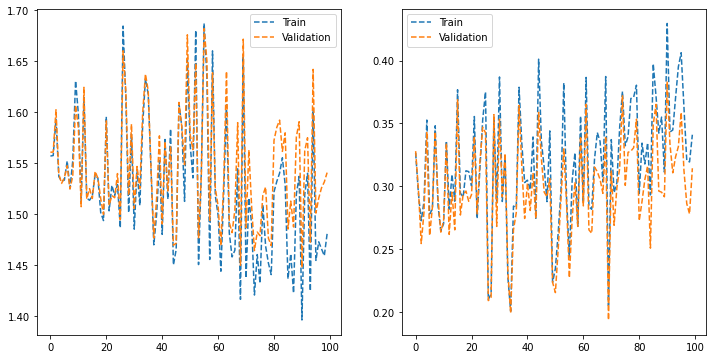

In [14]:
# Plot results
plt.figure(figsize=(12, 6))

epochs = np.arange(100)

plt.subplot(1, 2, 1)

plt.plot(epochs, T_LOSS, linestyle='--')
plt.plot(epochs, V_LOSS, linestyle='--')
plt.legend(["Train", "Validation"])

plt.subplot(1, 2, 2)
plt.plot(epochs, T_ACC, linestyle='--')
plt.plot(epochs, V_ACC, linestyle='--')

plt.legend(["Train", "Validation"])
plt.show()

2. Explore model variants with different pooling operations, keeping the word embeddings fixed during training or updating them, different depths and layer sizes for the multi-layerperceptron, etc. to find what works well on the validation set and describe the process through which you arrive at your final model.

**Choose Hyperparameters**

In [22]:
# Set model and training hyperparams

# Variable
maxDepth = 3
widths = [32, 64, 128]
pool_operations = ["mean", "max", "min", "mean-max", "max-min", "mean-min", "all"]
train_embed = [False, True]

# Fixed
batch_size = 128
learning_rate = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = "SGD"
epochs = 1000

In [16]:
# Create Dataloaders
train_loader = DataLoader(dataset=train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(dataset=val_data, shuffle=True, batch_size=len(val_data))

datasets = (train_data, val_data)
dataloaders = (train_loader, val_loader)

**Generate all model configurations using hyperparameters**

In [17]:
# Create every possible configuration of the model
def create_models(maxdepth, widths, pools, trainembds):

  models = dict()
  i = 1

  for t in trainembds:
    for p in pools:
      if p == "mean" or p == "max" or p == "min":
        input_layer = 300
      elif p == "mean-max" or p == "max-min" or p == "mean-min":
        input_layer = 600
      elif p == "all":
        input_layer = 900
      for d in range(maxdepth+1):
        if d == 0:
          Layer = [input_layer, 5]
          models["Model {}".format(i)] = {"Layers": Layer, "pool": p, "train_embed": t}
          i += 1
        else:
          for w in widths:
            # CONFIGURE MLP LAYERS
            Layer = [w] * d
            Layer.insert(0, input_layer)
            Layer.insert(4, 5)

            # CREATE A CONFIG
            models["Model {}".format(i)] = {"Layers": Layer, "pool": p, "train_embed": t}
            i += 1

  return models

In [18]:
def create_history(maxdepth, widths, pools, trainembds, filename):
  
  models = create_models(maxdepth, widths, pools, trainembds)

  print("Number of Configurations to Train = {}".format(len(models)))

  # Create train results dictionary
  train_results = dict()

  for model in models:

    # Load model config
    model_config = models[model]

    # Setup filename convention
    layers = model_config["Layers"]
    pool = model_config["pool"]
    train_embed = model_config["train_embed"]

    # Create key in dict
    train_results[model] = {"config": {"Layers":layers, "Pool":pool, "Train Embed":train_embed}, 
                            "results": {"Train Loss":[], "Validation Loss":[], "Train Accuracy":[], "Validation Accuracy":[]}, 
                            "done":False}

  # Write the experiment dictionary to a json file
  with open(filename, 'w', encoding='utf-8') as f:
    json.dump(train_results, f, ensure_ascii=False, indent=4)

**Train every configuration**

In [23]:
# results_file = "results/train_results_BS{}_OPTIM{}_E{}.json".format(batch_size, optimizer, epochs)
results_file = "results/train_results_sample_2.json"

if not os.path.exists(results_file):
  # Create training history file
  create_history(maxDepth, widths, pool_operations, train_embed, results_file)

# Load the experiment data file
with open(results_file, 'r', encoding='utf-8') as f:
  train_results = json.load(f)

# Train all configurations
for i, model in enumerate(train_results):

  print(">> Training {}".format(model))

  # Load model configuration
  model_config = train_results[model]["config"]
  layers = model_config["Layers"]
  pool = model_config["Pool"]
  train_embd = model_config["Train Embed"]

  # Only train the model if it hasn't been trained before
  if not train_results[model]["done"]:

    # SETUP MODEL
    mlp = MLP(Layers=layers,
              embeddings=weights,
              pool_type=pool,
              train_embed=train_embd)

    # SET OPTIMIZER
    optim = torch.optim.Adam(mlp.parameters()) if optimizer == "Adam" else torch.optim.SGD(mlp.parameters(), lr=learning_rate)

    # BEGIN TRAINING
    train_losses, val_losses, train_accs, val_accs = train(mlp, criterion, datasets, dataloaders, optim, epochs=epochs, verbose=0)

    # Update dictionary
    train_results[model]["results"]["Train Loss"] = train_losses
    train_results[model]["results"]["Validation Loss"] = val_losses
    train_results[model]["results"]["Train Accuracy"] = train_accs
    train_results[model]["results"]["Validation Accuracy"] = val_accs

    # Log that the model has been trained
    train_results[model]["done"] = True

  # We update the .json dictionary every 18 configurations
  if (i+1)%7 == 0:
    print("Saving Results...")
    with open(results_file, 'w', encoding='utf-8') as f:
      json.dump(train_results, f, ensure_ascii=False, indent=4)

>> Training Model 1
>> Training Model 2
>> Training Model 3
>> Training Model 4
>> Training Model 5
>> Training Model 6
>> Training Model 7
Saving Results...
>> Training Model 8
>> Training Model 9
>> Training Model 10
>> Training Model 11
>> Training Model 12
>> Training Model 13
>> Training Model 14
Saving Results...
>> Training Model 15
>> Training Model 16
>> Training Model 17
>> Training Model 18
>> Training Model 19
>> Training Model 20
>> Training Model 21
Saving Results...
>> Training Model 22
>> Training Model 23
>> Training Model 24
>> Training Model 25
>> Training Model 26
>> Training Model 27
>> Training Model 28
Saving Results...
>> Training Model 29
>> Training Model 30
>> Training Model 31
>> Training Model 32
>> Training Model 33
>> Training Model 34
>> Training Model 35
Saving Results...
>> Training Model 36
>> Training Model 37
>> Training Model 38
>> Training Model 39
>> Training Model 40
>> Training Model 41
>> Training Model 42
Saving Results...
>> Training Model 4

KeyboardInterrupt: ignored

3. Train your final model to convergence on the training set using an optimisation algorithm of your choice.

4. Provide a plot of the loss on the training set and validation set for each epoch of training.

5. Provide the final accuracy on the training, validation, and test set.

6. Provide a selection of the classification decisions of the final model for 5 opinionated sentences from movies reviews that you find online – perhaps for a movie you liked, or did not like? Remember to provide a links to the reviews from which you selected the sentences.

# Old Code

In [ ]:
# from tqdm import tqdm

# sentences = ssttrainxs[:5] #["My name is Sam", "I study in the UK", "I am twenty one years old"]
# for epoch in tqdm(range(3)):
#   #print("Epoch {}".format(epoch))
#   for i in range(len(sentences)):
#     print("Processing Sentence {}".format(i+1))
#     words = sentences[i]
#     vectors = [w2v[word] for word in words if word in w2v]
#     vectors = torch.as_tensor(vectors)
#     print("Sentence {} shape: {}".format(i+1, vectors.size()[0]))
#     pool = torch.mean(vectors, 1)
#     print("Shape after pooling : {}".format(pool.size()))

In [ ]:
# Create Data Class
class Data(Dataset):

  # Constructor
  def __init__(self, x_values, y_values, embedding, pool_type):

    # Compute the sentence encoding by pooling over the set of embedding vectors for each sentence
    self.x = self.compute_embedding(x_values, embedding, pool_type)

    # Store the sentence sentiment classes as a tensor
    self.y = torch.as_tensor(y_values)

    # store number of sentences in the dataset
    self.len = self.y.size()[0]
    
  # Getter
  def __getitem__(self, index):
    return self.x[index], self.y[index]

  # Get Length
  def __len__(self):
    return self.len

  # Compute embedding
  def compute_embedding(self, x_values, embedding, pool_type):

    sentences = torch.zeros(len(x_values), 300)

    for (i, x) in enumerate(x_values):
      # Create embedding vector using pretrained word2vec model
      word_embeddings = []
      for word in x:
        if word in embedding:
          word_embeddings.append(embedding[word])
        else:
          word_embeddings.append(embedding['UNK'])
      word_embeddings = torch.as_tensor(word_embeddings)

      # Perform pooling operation on all word embeddings to compute a final vector encoding for our sentence
      if pool_type == 'mean':
        sentence_pooled = torch.mean(word_embeddings, 0)
      elif pool_type == 'max':
        sentence_pooled = torch.max(word_embeddings, 0)
      elif pool_type == 'min':
        sentence_pooled = torch.min(word_embeddings, 0)
    
      sentences[i] = sentence_pooled

    return sentences